## Visualize image-specific class saliency with backpropagation

---

The gradients obtained can be used to visualise an image-specific class saliency map, which can gives some intuition on regions within the input image that contribute the most (and least) to the corresponding output.

More details on saliency maps: [Deep Inside Convolutional Networks: Visualising Image Classification Models and Saliency Maps](https://arxiv.org/pdf/1312.6034.pdf).

### 0. Set up

In [1]:
# Install flashtorch if you don't have it

# !pip install flashtorch

In [25]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import os
import gc
import sys
import json
import webdataset as wds

sys.path.append('..')

import matplotlib.pyplot as plt
import torchvision.models as models

from flashtorch.utils import apply_transforms, load_image
from flashtorch.saliency import Backprop

from model.baseline_3d_cnn import *
%load_ext autoreload
%autoreload 2

In [11]:
data_dir = '../data'
shards_dir = os.path.join(data_dir, 'shards_new')

# Opening JSON file
with open('../parameters.json') as json_file:
    parameters = json.load(json_file)

batch_size = parameters['batch_size']
shard_size = parameters['shard_size']
parameters

{'batch_size': 16, 'shard_size': 16}

In [17]:
urls = [os.path.join(shards_dir, it) for it in os.listdir(shards_dir) if it.endswith('.tar')]
wds_len = len(urls)*shard_size//batch_size

image_dataset = (
    wds
    .WebDataset(urls, length=wds_len)
    .shuffle(shard_size)
    .decode('torch')
    .to_tuple('volumes.pyd', 'labels.pyd', 'studynames.pyd')
    .batched(batch_size)
#     .map_tuple(pre_transforms, identity, identity)
)

image_loader = torch.utils.data.DataLoader(image_dataset, num_workers=0, batch_size=None)

In [18]:
gc.collect()

74

### 1. Load an image 

In [20]:
patient_num = 1

for t, (x, y, z) in enumerate(image_loader):
    if t > 0:
        break
    img_df = x[patient_num, :, :, :].detach().numpy()
    img_y = y[patient_num, :]
del x # For now for memory reasons

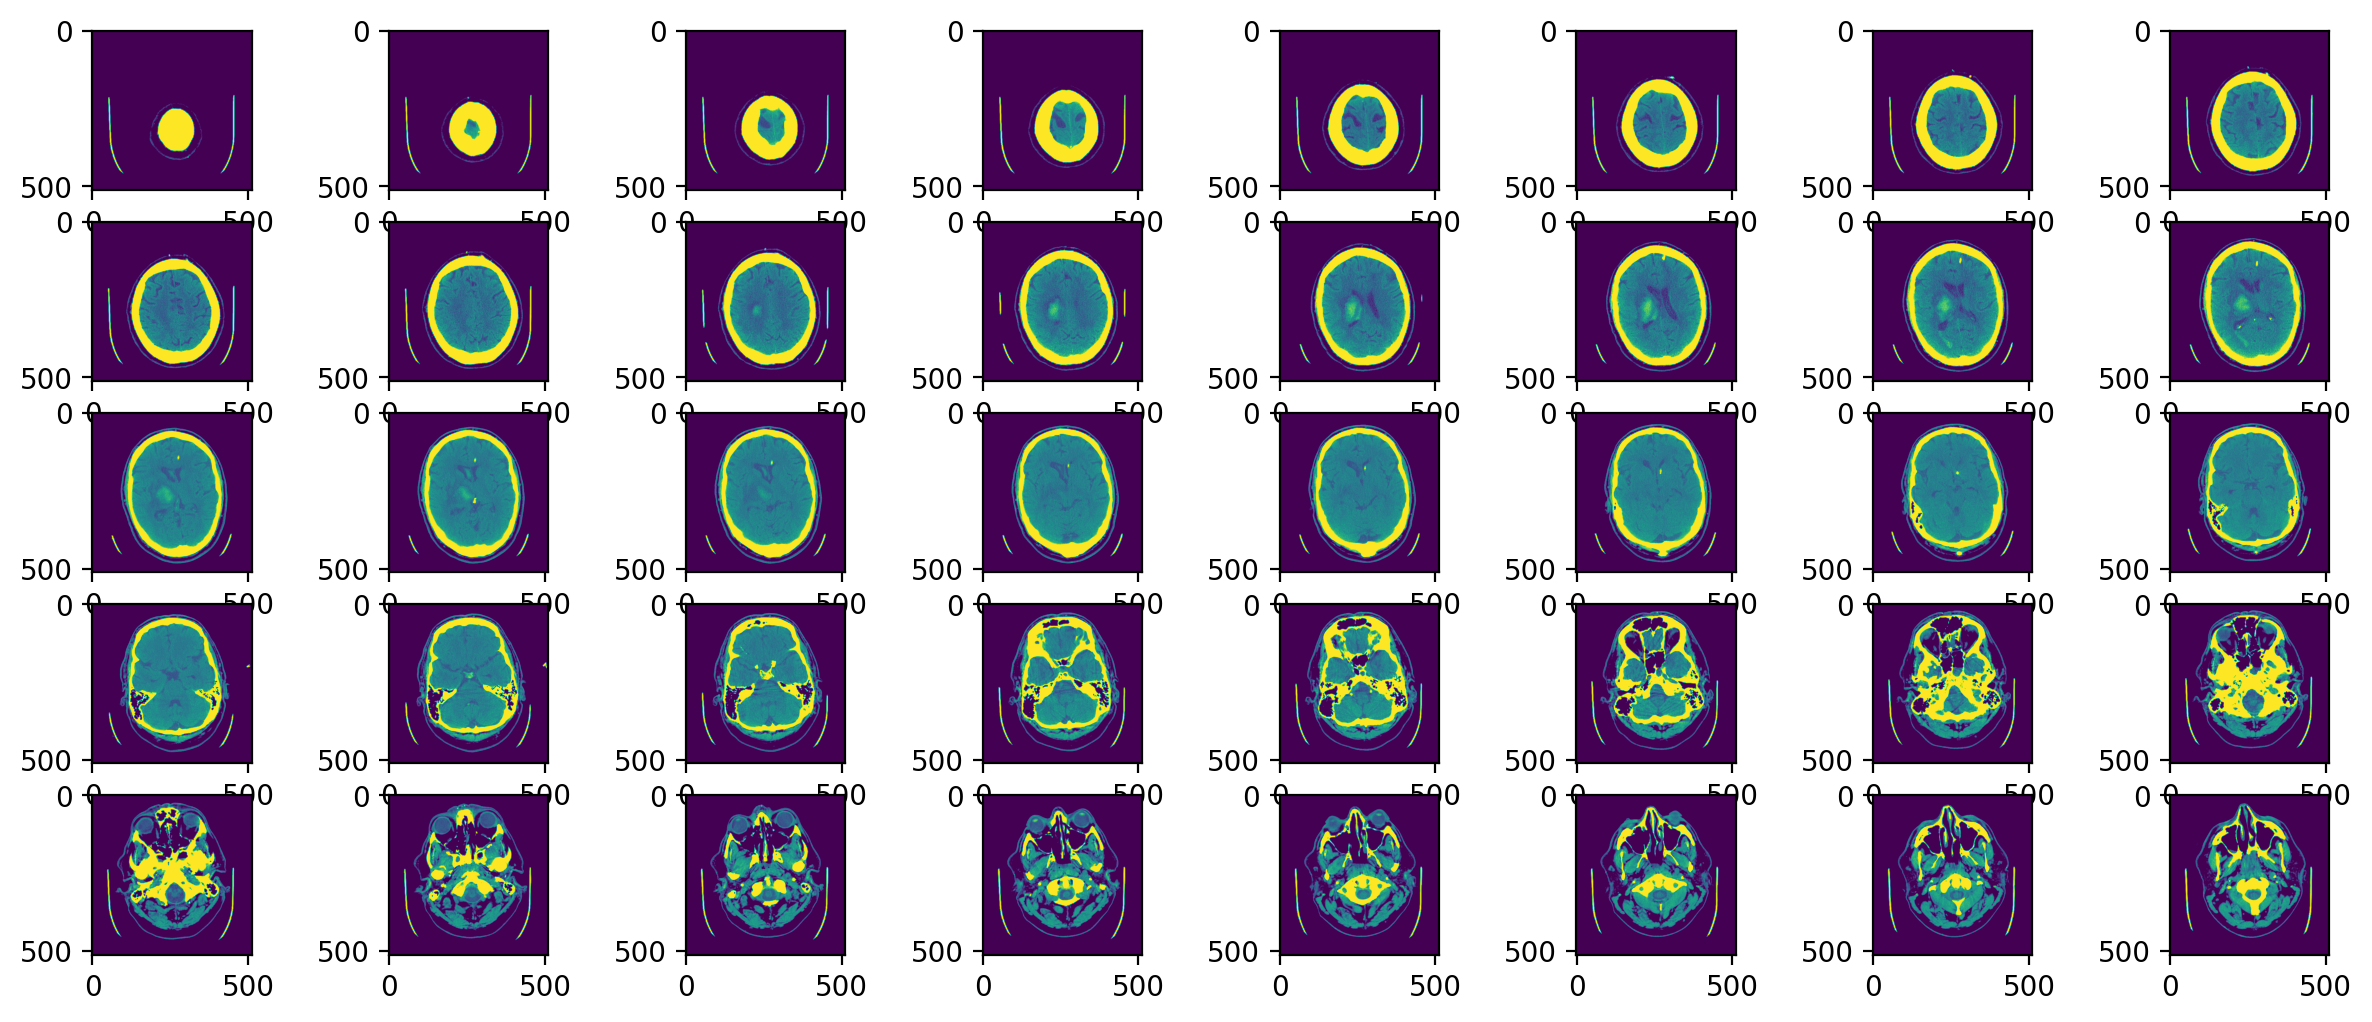

In [21]:
fig, axs = plt.subplots(5,8, figsize=(15, 6))
axs = axs.ravel()
for i in range(40):
    axs[i].imshow(img_df[i,:,:])

### 2. Load a pre-trained Model

In [40]:
ckpt_dir = os.path.join('..', 'runs', 'baseline_c3fc3')
ckpt_path = os.path.join(ckpt_dir, 'Checkpoints', 'ep_5_iter_65_ckpt.pt')
ckpt = torch.load(ckpt_path)

ckpt_model = baseline_3DCNN(in_num_ch=1)
ckpt_model.load_state_dict(ckpt['model_state_dict'])


<All keys matched successfully>

### 3. Create an instance of Backprop with the model

In [41]:
backprop = Backprop(ckpt_model)

### 4. Visualize saliency maps

torch.Size([40, 512, 512])

In [43]:
# Transform the input image to a tensor

# img_t = apply_transforms(img_df)
img_t = torch.Tensor(img_df).unsqueeze(axis=0)
print(img_t.shape)

# Set a target class from ImageNet task: 24 in case of great gray owl

# Ready to roll!
backprop.visualize(img_t, img_y, guided=True, use_gpu=True)

torch.Size([1, 40, 512, 512])


RuntimeError: Boolean value of Tensor with more than one value is ambiguous

### 5. What about other birds?

What makes peacock a peacock...?

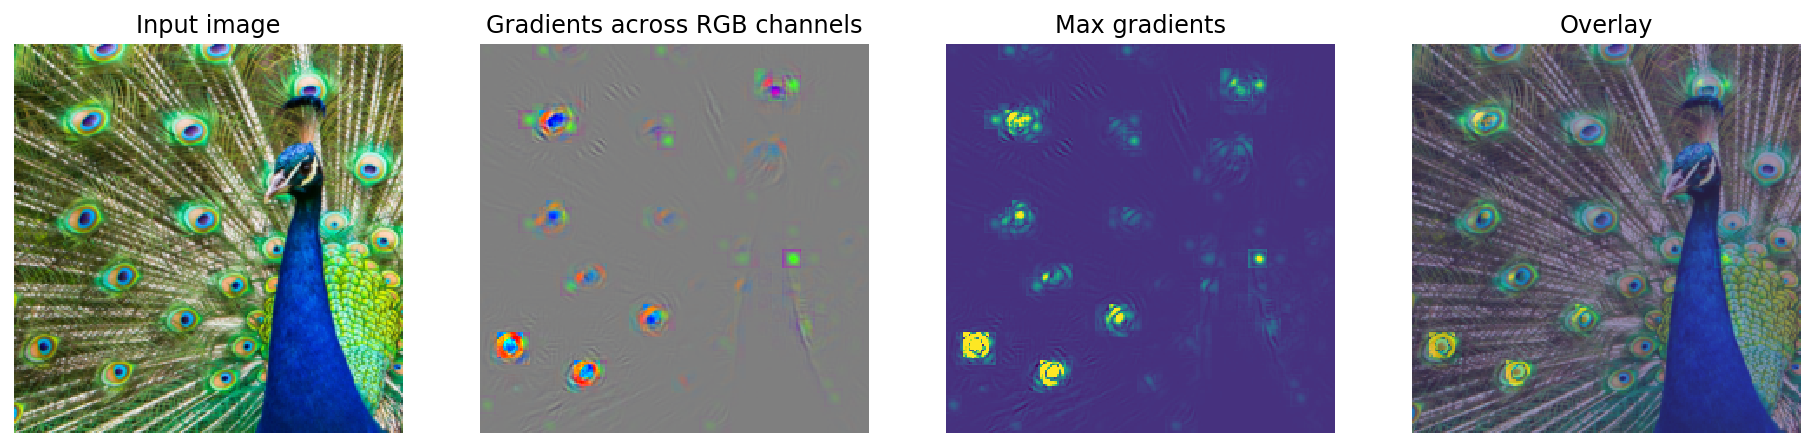

In [7]:
peacock = apply_transforms(load_image('./images/peacock.jpg'))
backprop.visualize(peacock, 84, guided=True)

Or a toucan?

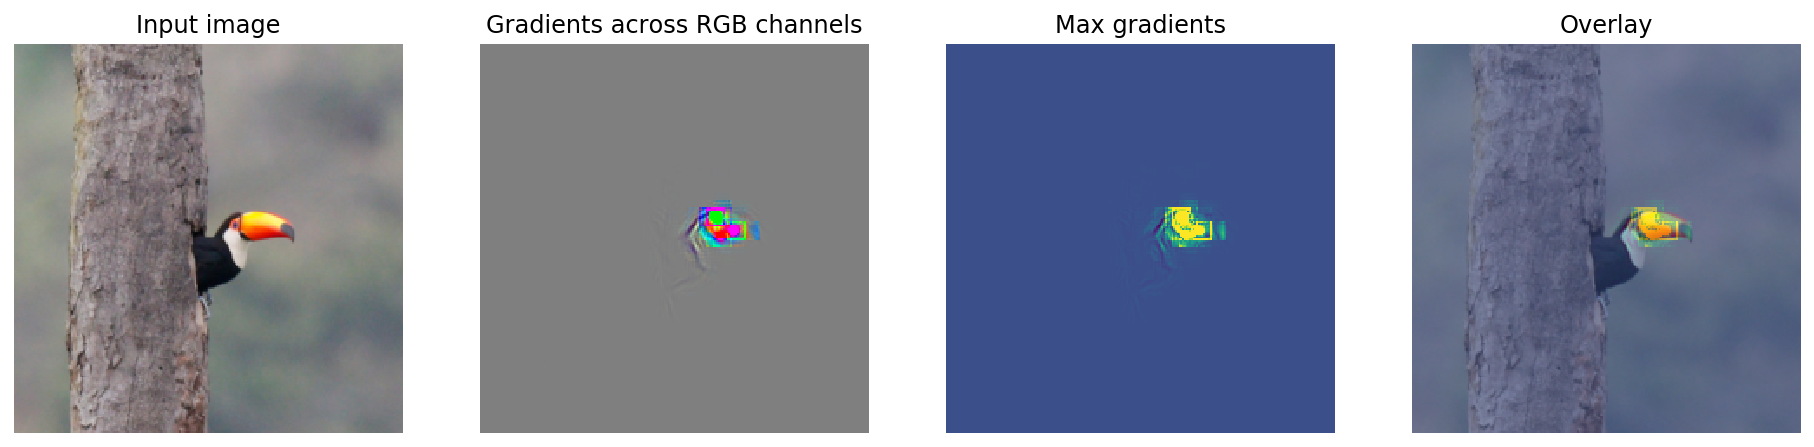

In [8]:
toucan = apply_transforms(load_image('./images/toucan.jpg'))
backprop.visualize(toucan, 96, guided=True)

Please try out other models/images too!